# Visualize queries embeddings.
Encode all queries that were correclty predicted with NetBERT and plot them with tsne.

In [37]:
import os
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(font_scale=2, style="whitegrid", font="sans-serif")

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 1. Load test set queries

In [38]:
def load_sentences(dirpath):
    """
    """
    with open(os.path.join(dirpath, 'map_classes.json')) as f:
        class_mappings = json.load(f)
    
    # Create dataframe.
    df_right = pd.read_csv(os.path.join(dirpath, 'preds_right.csv'), index_col=0)
    df_wrong = pd.read_csv(os.path.join(dirpath, 'preds_wrong.csv'), index_col=0)
    df = pd.concat([df_right, df_wrong], ignore_index=True)

    # Create columns with classes.
    df['Class'] = df.apply(lambda row: class_mappings[str(row.Class_id)], axis=1)

    # Drop prediction.
    df.drop(['Prediction_id'], axis=1, inplace=True)
    return df


df = load_sentences('./output/netbert-final/')
df

,Sentence,Class_id,Class
0,ASA 5585-X SSP EP 20/60,0,Install & Upgrade Guides
1,Cisco DNA Center as a Multi-Host Cluster,1,Configuration
2,Cisco Catalyst 3650 Series Switches: Configuri...,1,Configuration
3,dhcp snooping catalyst 4500,1,Configuration
4,3650 aaa group server tacacs,1,Configuration
...,...,...,...
4803,apic discovery switch,0,Install & Upgrade Guides
4804,catalyst 2960 config,1,Configuration
4805,what is the ir809?,1,Configuration
4806,Catalyst 9200 iOS,1,Configuration


## 2. Get [CLS] representation of these queries.

In [39]:
def encode_sentences(model_name_or_path, batch_size, df, cls_token=False):
    """
    Encode corpus of sentences with CPU or GPU(s).
    
    Note that multi-GPU encoding is quite imbalanced due to the use
    of 'torch.nn.DataParallel' which loads the model in the main GPU
    but also gathers the output of all other GPUs back to the main one.
    As a result, the main GPU is three times more loaded than the others.
    Although the other GPUs are not fully loaded, one can not increase the
    batch size as it would result in an 'out of memory' error in the main GPU.
    Here, the max batch size is 128.
    
    Note that the GPU utilisation with 'torch.nn.DataParallel' is very volatile.
    GPUs are never running at 100%, which slows the process.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True) # Will output all hidden_states.
    
    print("   Setting up CUDA & GPU...")
    device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print("   Encoding sentences...")
    all_embeddings = []
    sentences = df.Sentence.values
    iterator = range(0, len(sentences), batch_size)
    for batch_idx in tqdm(iterator, desc="Batches"):
        
        # Get the batch.
        batch_start = batch_idx
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        
        # Tokenize each sentence of the batch.
        tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in batch_sentences]
        
        # Pad/Truncate sentences to max_len or 512.
        lengths = [len(i) for i in tokenized]
        max_len = max(lengths) if max(lengths) <= 512 else 512
        padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")
        
        # Create attention masks.
        attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.
        
        # Convert inputs to torch tensors.
        input_ids = torch.tensor(padded)
        attention_mask = torch.tensor(attention_mask)
        
        # Push inputs to GPUs.
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        # Encode batch.
        model.eval()
        with torch.no_grad():
            # output is a 2-tuple where:
            #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
            #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
            #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
            output = model(input_ids, attention_mask=attention_mask)
            last_hidden_states = output[0]
        
        if cls_token:
            # Take the embedding of the CLS token as the embedding of the sentence.
            sentence_embeddings = [embeddings[0].to('cpu').numpy() for embeddings in last_hidden_states]
        else:
            # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
            sentence_embeddings = [torch.mean(embeddings, dim=0).to('cpu').numpy() for embeddings in last_hidden_states]
        all_embeddings.extend(sentence_embeddings)
    
    # Create dataframe for storing embeddings.
    all_embeddings = np.array(all_embeddings)
    cols = ['feat'+str(i+1) for i in range(all_embeddings.shape[1])]
    df_embeddings = pd.DataFrame(data=all_embeddings[:,:], columns=cols)
    df_embeddings['Sentence'] = sentences
    df_embeddings['Class'] = df.Class.values
    df_embeddings['Class_id'] = df.Class_id.values
    return df_embeddings

### 2.1. With fine-tuned NetBERT

In [40]:
df_netbert = encode_sentences(model_name_or_path='./output/netbert-final/', 
                                      batch_size=128,
                                      df=df,
                                      cls_token=True)
df_netbert.head()

   Loading pretrained model/tokenizer...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

   Setting up CUDA & GPU...
   Encoding sentences...


Batches: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat762,feat763,feat764,feat765,feat766,feat767,feat768,Sentence,Class,Class_id
0,-0.671668,-1.182305,0.764572,-0.966653,-0.113947,0.626759,0.287709,0.477582,-0.349046,-1.390213,...,0.161785,-0.776574,0.488948,-0.398819,-0.425137,0.803834,-0.519800,ASA 5585-X SSP EP 20/60,Install & Upgrade Guides,0
1,-1.528123,0.457363,0.235728,0.530495,-1.164741,1.293144,-0.988077,0.466835,0.979315,-0.563682,...,-0.791996,0.724087,0.031501,0.901555,0.220298,-1.189235,-0.693121,Cisco DNA Center as a Multi-Host Cluster,Configuration,1
2,-1.769625,0.440065,0.231293,1.284986,-0.201410,1.196321,-0.590471,0.574112,0.527524,-0.582811,...,-0.530438,0.059551,-0.292169,1.066434,0.221258,-1.073736,-0.087916,Cisco Catalyst 3650 Series Switches: Configuri...,Configuration,1
3,-1.664497,0.376277,0.332815,1.295098,-0.196419,1.017563,-0.573322,0.707802,0.373486,-0.537609,...,-0.364461,-0.081614,-0.010963,1.019280,0.397287,-1.019336,-0.206120,dhcp snooping catalyst 4500,Configuration,1
4,-1.546195,0.523354,0.269693,1.308507,-0.160414,0.803490,-0.569628,0.579871,0.254071,-0.429176,...,-0.873530,-0.048688,-0.224891,0.831638,0.116811,-0.879873,-0.025470,3650 aaa group server tacacs,Configuration,1


### 2.2. With fine-tuned BERT

In [41]:
df_bert = encode_sentences(model_name_or_path='./output/bert_base_cased/', 
                                      batch_size=128,
                                      df=df,
                                      cls_token=True)
df_bert.head()

   Loading pretrained model/tokenizer...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

   Setting up CUDA & GPU...
   Encoding sentences...


Batches: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat762,feat763,feat764,feat765,feat766,feat767,feat768,Sentence,Class,Class_id
0,1.013545,-1.076791,-0.110877,0.231949,-0.320420,-0.506851,0.573740,-0.137533,-0.040764,-0.953288,...,-1.200342,-0.015996,0.276274,0.749596,-0.198639,-1.052420,0.233151,ASA 5585-X SSP EP 20/60,Install & Upgrade Guides,0
1,0.911051,-2.012108,0.065655,0.759592,-1.071576,-0.838661,0.972774,0.701629,0.218280,0.380144,...,0.089581,-0.166324,-0.083069,0.831009,-1.027832,-0.655860,-0.747776,Cisco DNA Center as a Multi-Host Cluster,Configuration,1
2,0.668073,-1.057851,0.242018,0.333769,-1.017533,-0.842784,1.327694,1.003663,0.240160,0.162674,...,0.806284,-0.103039,-0.696934,0.880082,-1.368239,-0.124210,-0.367726,Cisco Catalyst 3650 Series Switches: Configuri...,Configuration,1
3,1.006791,-1.180978,0.250033,0.559537,-1.431763,-0.681704,0.979780,0.979179,0.572794,-0.248197,...,0.638957,0.012955,-0.684969,1.185383,-1.355582,-0.292842,-0.194148,dhcp snooping catalyst 4500,Configuration,1
4,0.923041,-1.167987,0.118713,0.426079,-1.126580,-0.898713,1.275261,0.960644,0.482749,-0.021212,...,0.707708,-0.066722,-0.760166,0.821627,-1.351023,-0.059909,-0.279597,3650 aaa group server tacacs,Configuration,1


## 3. Visualize embeddings with PCA50 + tsne

In [45]:
def visualize_embeddings(df_embeddings, fig_name):
    """
    """
    sentence_embeddings = df_embeddings.iloc[:,:-3].values
    pca_50 = PCA(n_components=50, random_state = 6)
    pca_result_50 = pca_50.fit_transform(sentence_embeddings)
    print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

    #for i in range(5, 101, 5):
    i = 60
    print("\nPerplexity: {}".format(i))
    print("---------------")
    tsne = TSNE(n_components=3, 
                perplexity=i, # usually in the range [5, 50] -> perplexity is related to the number of nearest neighbors (larger datasets usually require a larger perplexity).
                n_iter=2000, 
                learning_rate = 200, # usually in the range [10, 1000] -> If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours.
                random_state = 42, verbose=0)
    tsne_pca_results = tsne.fit_transform(pca_result_50)

    # Add results to dataframe
    pca50_tsne_df = df_embeddings.copy(deep=True)
    pca50_tsne_df['tsne-pca50-one'] = tsne_pca_results[:,0]
    pca50_tsne_df['tsne-pca50-two'] = tsne_pca_results[:,1]
    pca50_tsne_df['tsne-pca50-three'] = tsne_pca_results[:,2]

    # PCA in 2D
    fig = plt.figure(figsize=(15,25))
    ax1 = fig.add_subplot(2, 1, 1)
    g=sns.scatterplot(
            x = pca50_tsne_df['tsne-pca50-one'], 
            y = pca50_tsne_df['tsne-pca50-two'],
            hue = pca50_tsne_df['Class'],
            palette = "coolwarm")
    #ax1.set_title("2D PCA50+t-SNE")
    ax1.set_xlabel('tsne1', labelpad=20)
    ax1.set_ylabel('tsne2', labelpad=20)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles[1:], labels=labels[1:], loc='best', title="", bbox_to_anchor=(1, 1), ncol=1)
    #g.legend_.remove()

    # PCA in 3D
    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    scatter = ax2.scatter(
        xs=pca50_tsne_df['tsne-pca50-one'],
        ys=pca50_tsne_df['tsne-pca50-two'],
        zs=pca50_tsne_df['tsne-pca50-three'],
        c=pca50_tsne_df['Class_id'],
        cmap='coolwarm')
    classes = pca50_tsne_df.Class.unique().tolist()
    handles,_ = scatter.legend_elements(num=len(classes))
    ax2.legend(handles, classes, loc="upper right", title="", bbox_to_anchor=(1.45, 0.95))
    #ax2.set_title("3D PCA50+t-SNE")
    ax2.set_xlabel('tsne1', labelpad=20)
    ax2.set_ylabel('tsne2', labelpad=20)
    ax2.set_zlabel('tsne3', labelpad=20)

    output = "./figures/" + fig_name + ".pdf"
    plt.savefig(output, bbox_inches='tight')
    plt.show()
    return

### 3.1. NetBERT embeddings

Cumulative explained variation for 50 principal components: 0.9394727349281311

Perplexity: 60
---------------


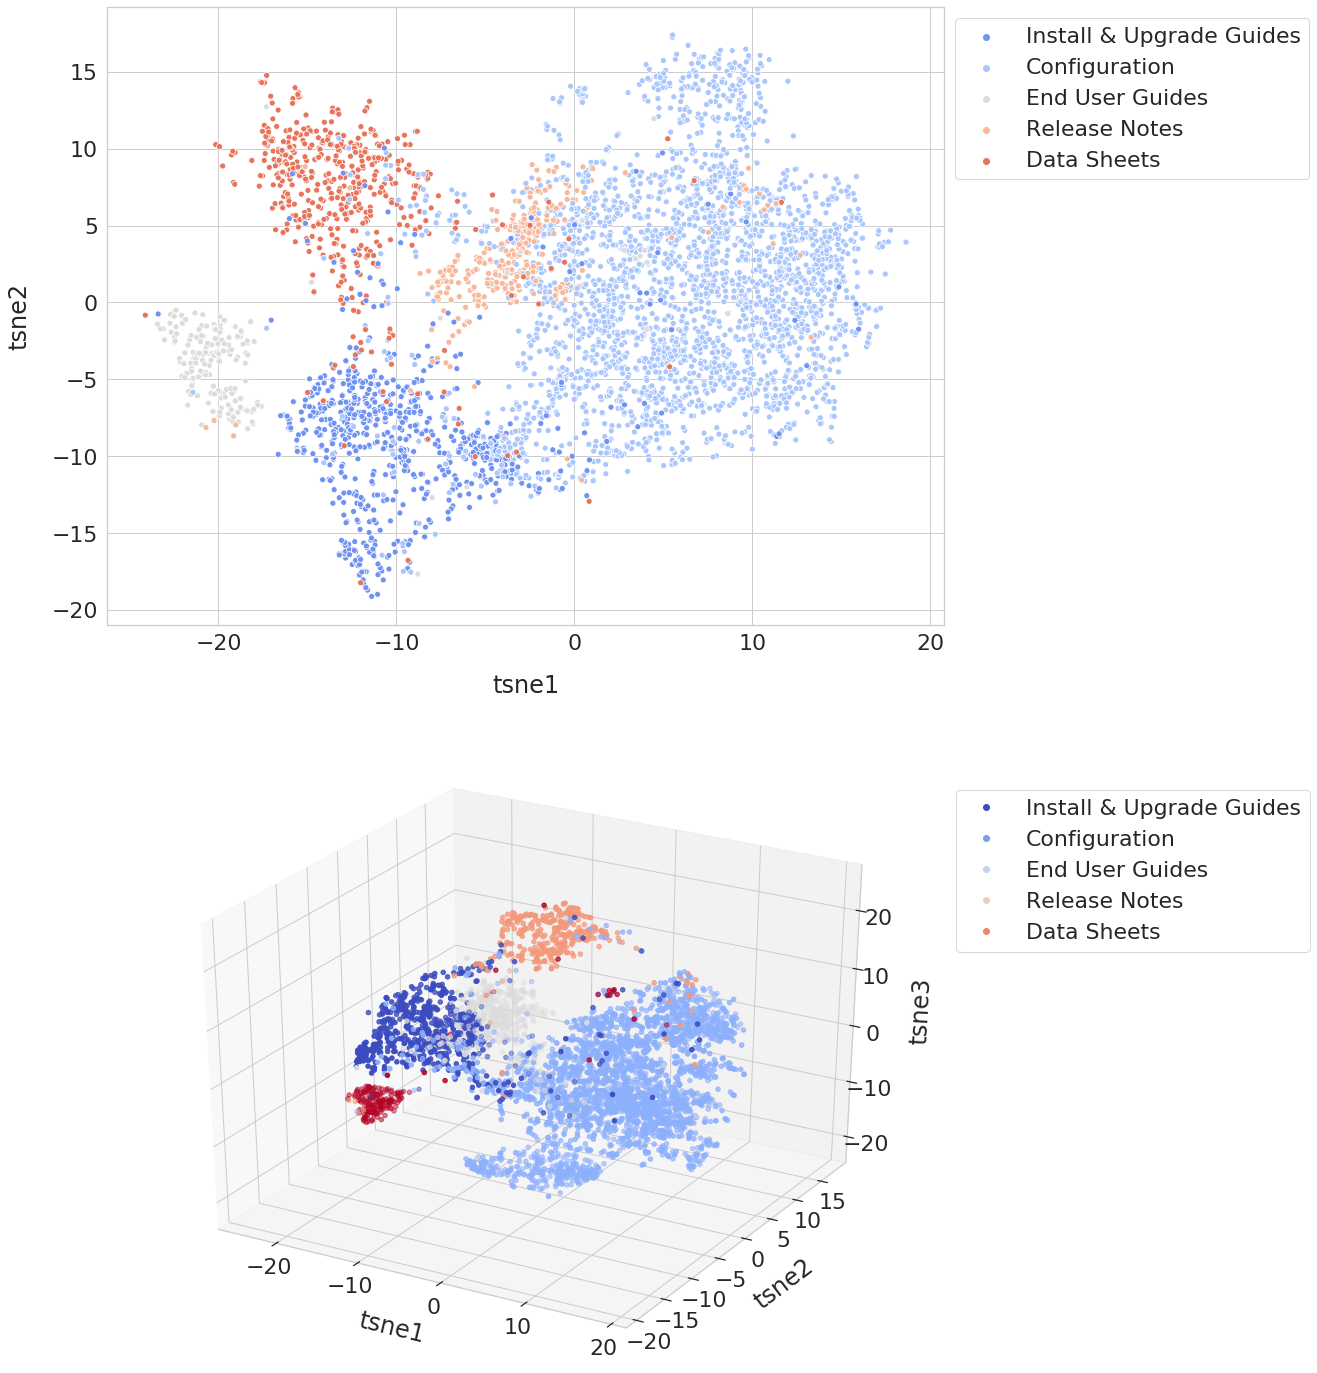

In [46]:
visualize_embeddings(df_netbert, "netbert_tsne")

### 3.1. BERT embeddings

Cumulative explained variation for 50 principal components: 0.9400256872177124

Perplexity: 60
---------------


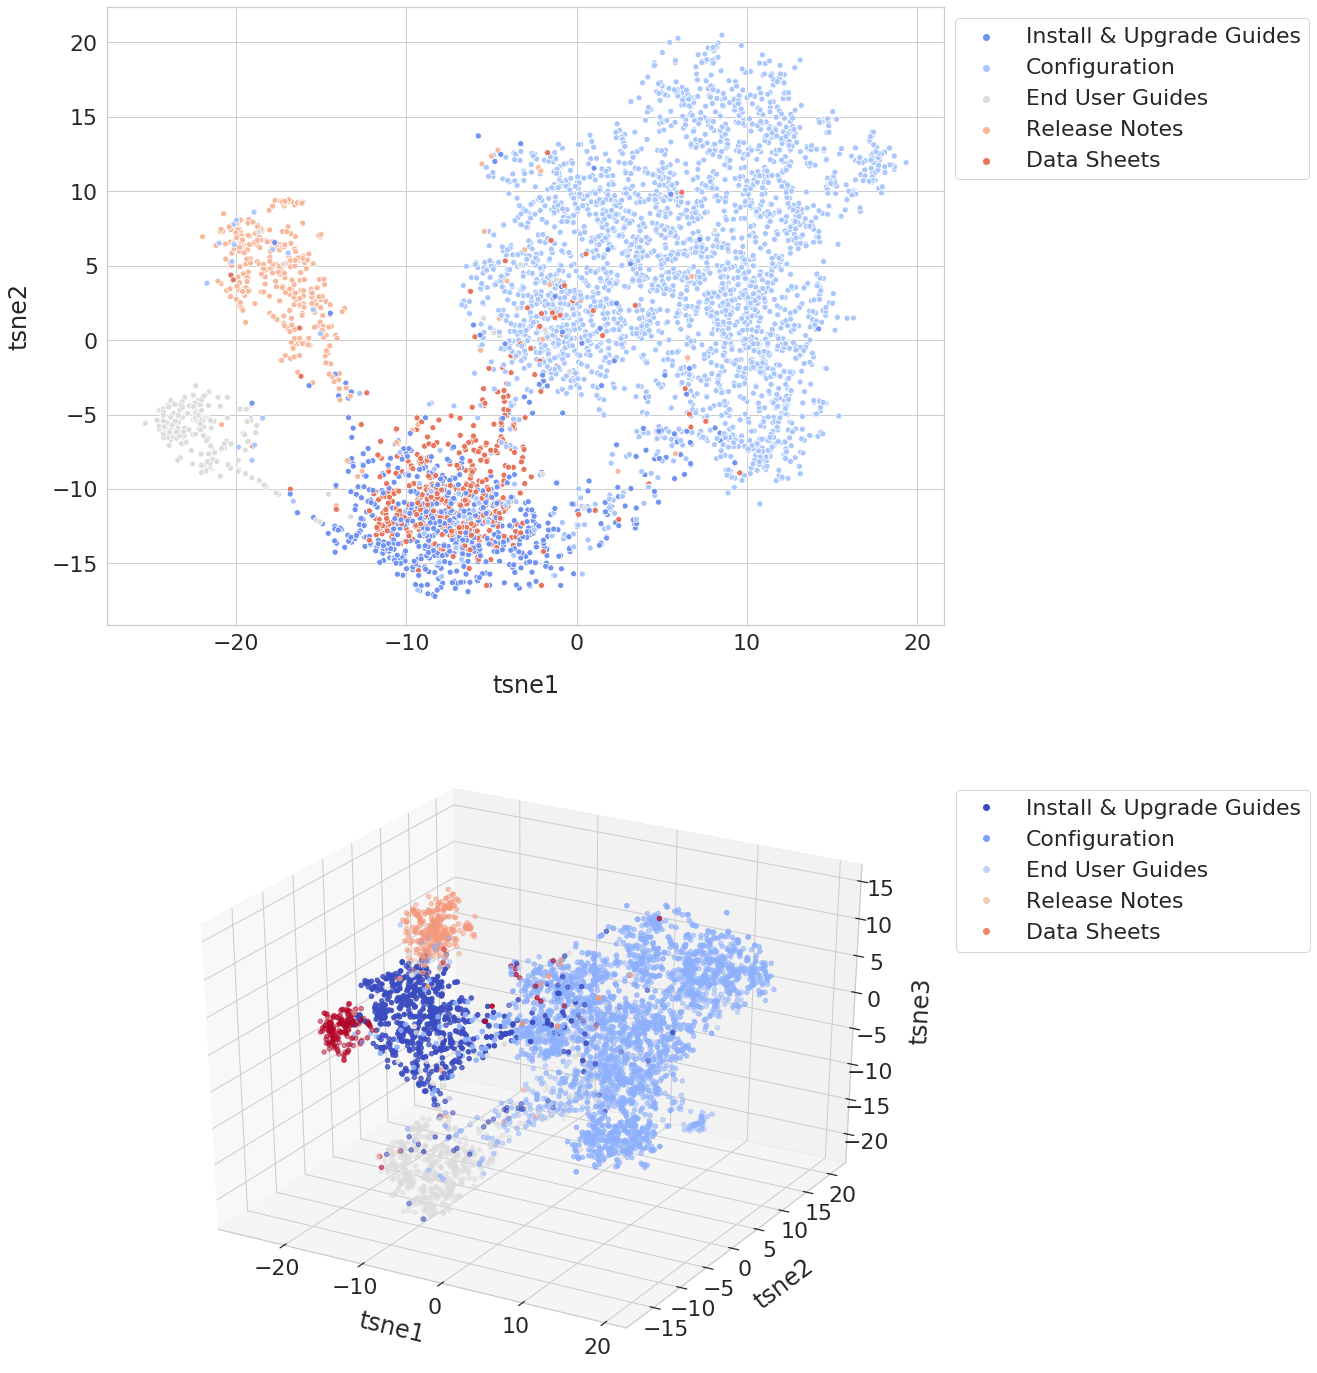

In [47]:
visualize_embeddings(df_bert, "bert_tsne")